# Проект по машинному обучению


### Информация о данных
Данные клиента за предыдущий до проверки факта оттока месяц:
* 'gender' — пол;
* 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
* 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
* Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
* 'Phone' — наличие контактного телефона;
* 'Age' — возраст;
* 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
* 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
* 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
* 'Group_visits' — факт посещения групповых занятий;
* 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
* 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
* 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
* 'Churn' — факт оттока в текущем месяце.

Целевая переменная: 'Churn'  (значение 0 или 1)

## Шаг 1. Загрузка данных

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
import itertools
import warnings
warnings.filterwarnings('ignore')

In [2]:
# загрузка и просмотр таблицы
try: 
    df = pd.read_csv('gym_churn.csv')
except: 
    df = pd.read_csv('/datasets/gym_churn.csv')

In [3]:
# просмотр таблицы
print(df.shape)
df.head()

(4000, 14)


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
# просмотр данных таблицы
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Все столбцы имеют числовой формат, пропусков в данных нет, можно приступать к изучению данных

## Шаг 2. Проведу исследовательский анализ данных (EDA)

In [5]:
# изучим средние значения и стандартные отклонения
df.describe()[1:].T.style.format('{:.3f}').background_gradient(cmap='Blues', axis=1)

,mean,std,min,25%,50%,75%,max
gender,0.510,0.500,0.000,0.000,1.000,1.000,1.000
Near_Location,0.845,0.362,0.000,1.000,1.000,1.000,1.000
Partner,0.487,0.500,0.000,0.000,0.000,1.000,1.000
Promo_friends,0.308,0.462,0.000,0.000,0.000,1.000,1.000
Phone,0.903,0.295,0.000,1.000,1.000,1.000,1.000
Contract_period,4.681,4.550,1.000,1.000,1.000,6.000,12.000
Group_visits,0.412,0.492,0.000,0.000,0.000,1.000,1.000
Age,29.184,3.258,18.000,27.000,29.000,31.000,41.000
Avg_additional_charges_total,146.944,96.356,0.148,68.869,136.220,210.950,552.591
Month_to_end_contract,4.323,4.191,1.000,1.000,1.000,6.000,12.000


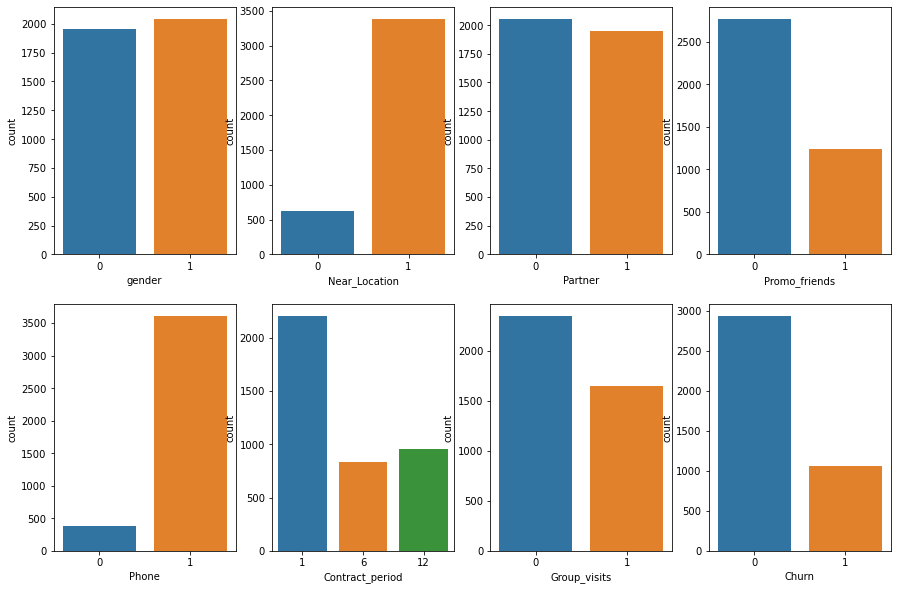

In [6]:
# визуализирую распределение по признакам
a = df[['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 'Contract_period', 'Group_visits', 'Churn']]
fig, axs = plt.subplots(2,4,figsize=(15,10))
axs = axs.flatten()
for i, column in enumerate(a.columns):
    sns.countplot(x = column, data=a, ax=axs[i])

Итак у нас распределение по полам примерно одинаково, в основном фитнес центр находится в районе работы или проживания клиента, сотрудников компании-партнёра и не, также примерно одинаково, клиентов по акции «приведи друга» около 30%, номера большинства клиентов имеются, преобладают абонементы сроком на 1 месяц, после на 12 месяцев и на 6, групповые занятия посещают около 40% клиентов и процент оттока клиентов составляет 26,5%.

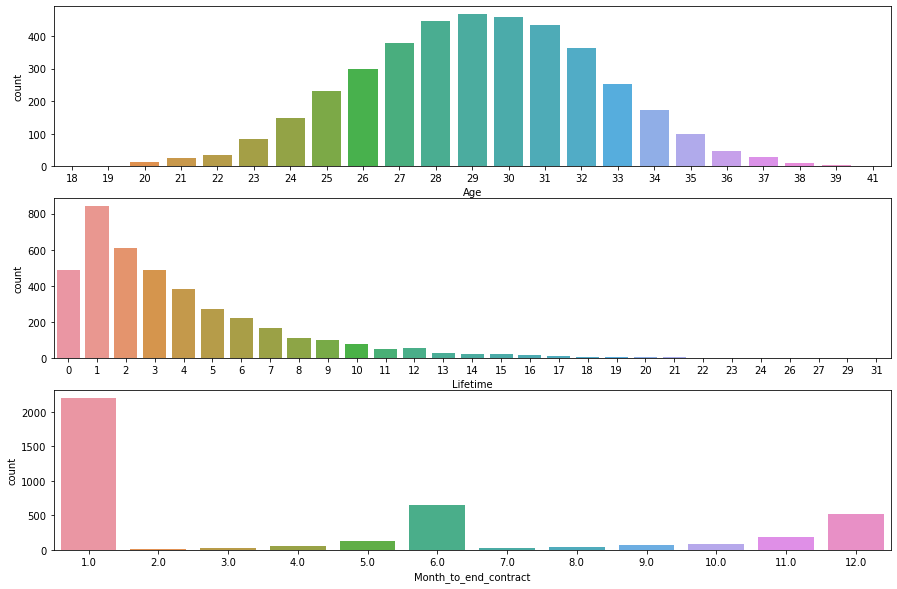

In [7]:
b = df[['Age', 'Lifetime', 'Month_to_end_contract']]
fig, axs = plt.subplots(3,figsize=(15,10))
axs = axs.flatten()
for i, column in enumerate(b.columns):
    sns.countplot(x = column, data=b, ax=axs[i])

Средний возраст посетителя 29 лет, а средний лайфтайм 3,7 месяцев, хотя на графике видно что преобладают посетители с лайфтамом 1 месяц, срок до окончания текущего действующего абонемента в среднем 4,3 месяца, но у более чем половины пользователей это 1 месяц.

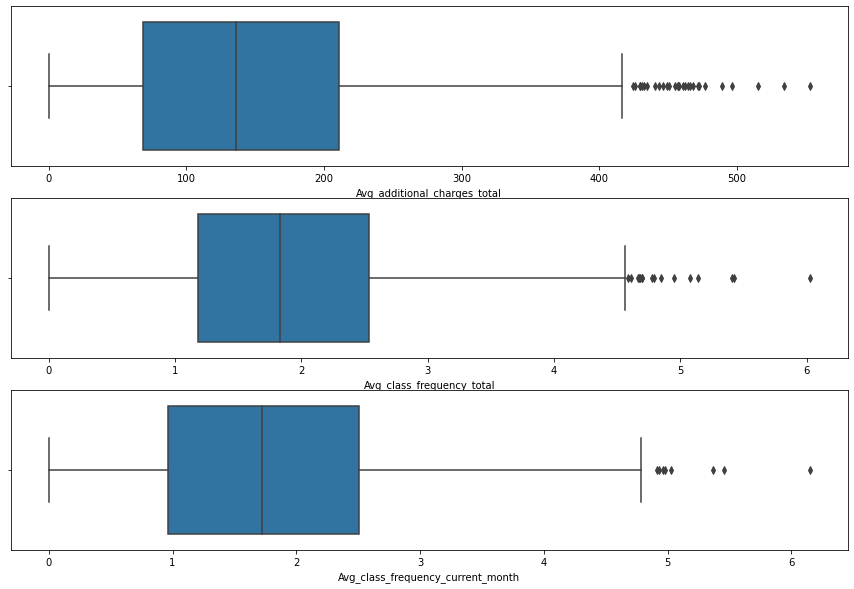

In [8]:
c = df[['Avg_additional_charges_total', 'Avg_class_frequency_total', 'Avg_class_frequency_current_month']]
fig, axs = plt.subplots(3,figsize=(15,10))
axs = axs.flatten()
for i, column in enumerate(c.columns):
    sns.boxplot(x = column, data=c, ax=axs[i])

суммарная выручка от других услуг фитнес-центра 146,9 но в целом значения довольно разбросаны, среднее количество посещений в неделю 1,8 на человека, а за последний месяц 1,7.

In [9]:
# Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался
df.groupby('Churn').mean().T.style.format('{:.3f}').background_gradient(cmap='Blues', axis=1)

Churn,0,1
gender,0.510,0.511
Near_Location,0.873,0.768
Partner,0.534,0.355
Promo_friends,0.354,0.184
Phone,0.904,0.903
Contract_period,5.747,1.729
Group_visits,0.464,0.269
Age,29.977,26.990
Avg_additional_charges_total,158.446,115.083
Month_to_end_contract,5.283,1.663


По всем признакам средние значения больше у оставшихся, кроме гендера и номера телефона эти метрики примерно одинаковы в обоих выборках.

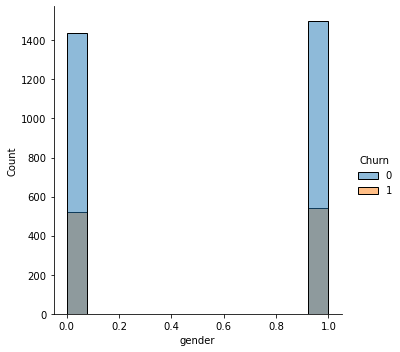

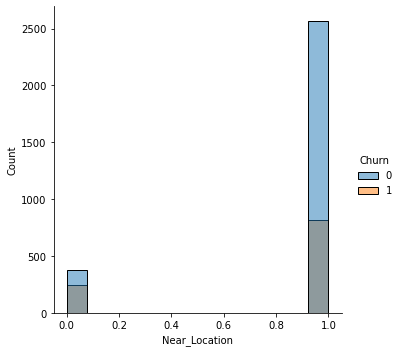

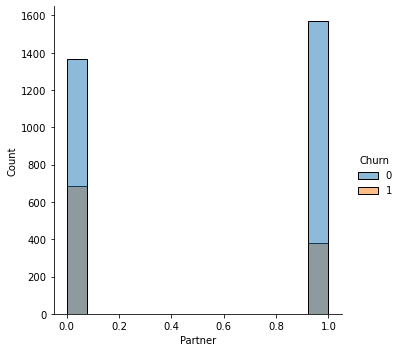

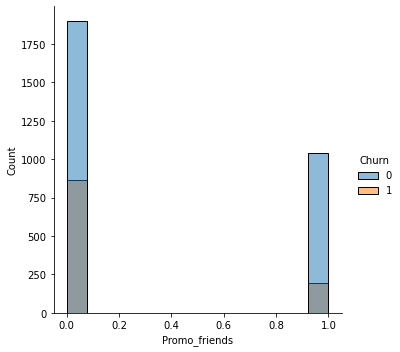

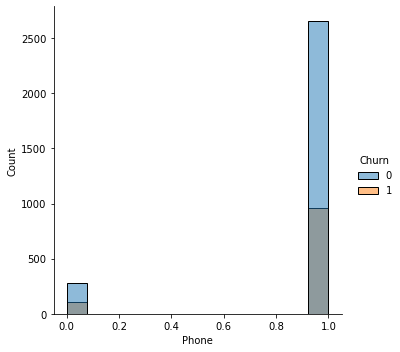

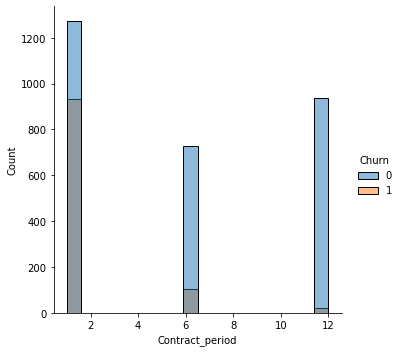

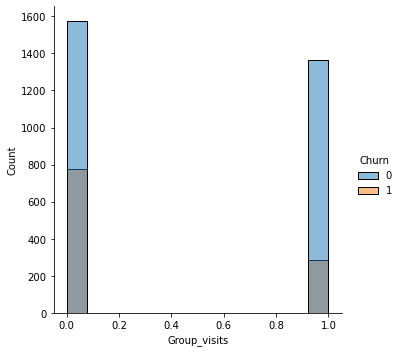

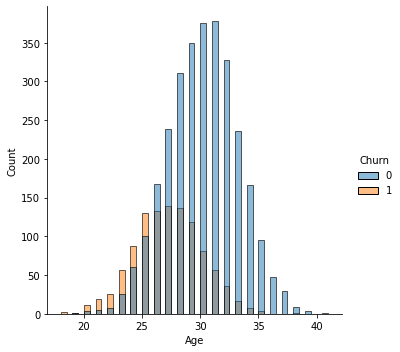

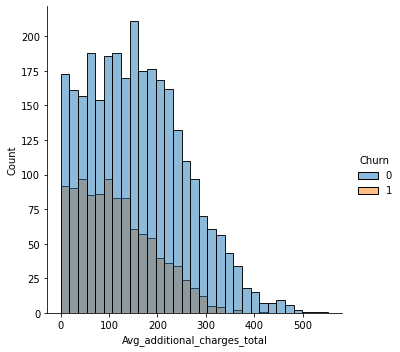

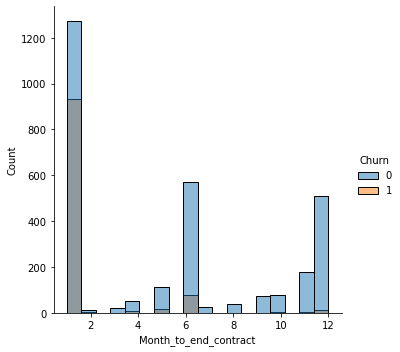

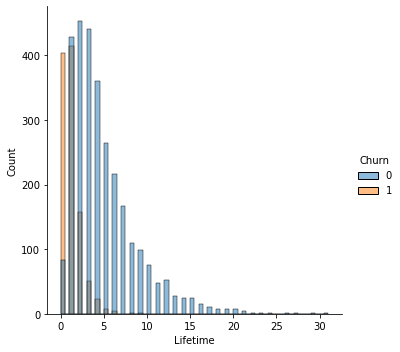

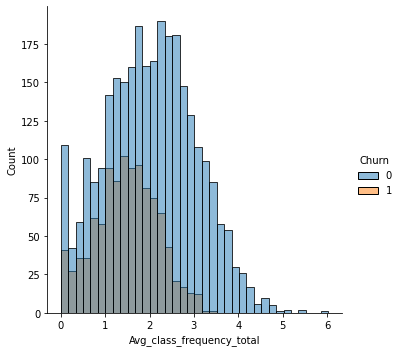

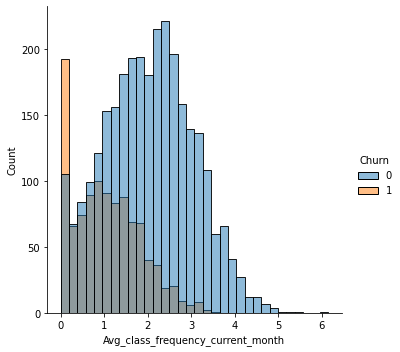

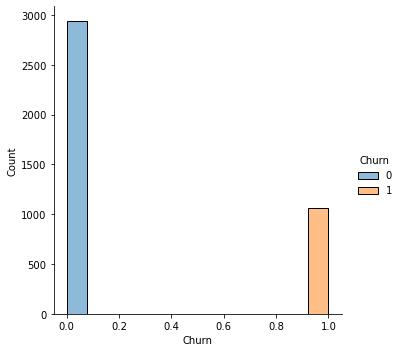

In [10]:
# Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл и тех, кто остался
for column in df.columns:
    sns.displot(x=df[column], hue="Churn", data=df)

По гистограммам видно что в выборке оставшихся, количество "партнеров" немного больше чем не партнеров, у отпавших наоборот. 
У оставшихся также намного больше количество тех, кто воспользовался акцией приведи друга относительно всех клиентов. Также бросается в глаза что оставшиеся намного чаще покупают абонементы на 6 и 12 месяцев, а еще они чаще посещают групповые занятия. В среднем оставшиеся старше отпавших и больше тратят. Их средний лайфтайм составляет 4,7 месяца против 0,9 у отпавших и в среднем количество посещений в неделю у оставшихся больше. 

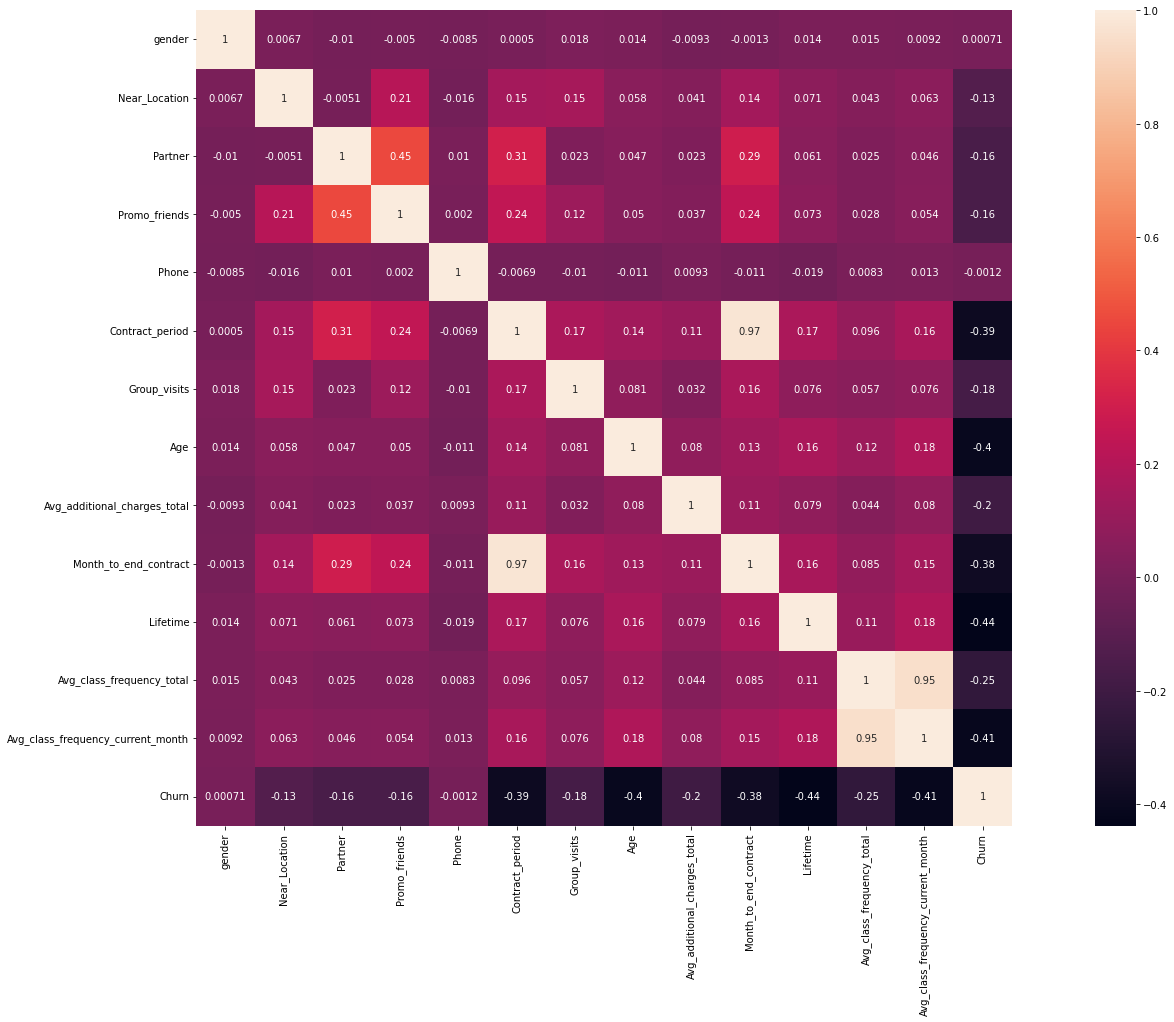

In [11]:
# посмотрим матрицу корреляций всех признаков
cm = df.corr() 
plt.figure(figsize=(30, 15))
sns.heatmap(cm, annot=True, square=True)
plt.show()

Похожие метрики сильно коррелируют, длительность текущего абонемента и срок до окончания абонемента, среднее количество посещений в неделю за последний месяц и общее среднее количество посещений в неделю. Так как эти метрики практически говорят об одном и том же и я не буду использовать линейные модели для машинного обучения удалять я их не буду.

## Шаг 3. Построю модель прогнозирования оттока клиентов

In [12]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
y = df['Churn']
X = df.drop(['Churn'], axis = 1)

In [13]:
# разделяем модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [14]:
# Обучим модель на train-выборке двумя способами: логистической регрессией и случайным лесом.
model_1 = LogisticRegression(random_state=0, solver='liblinear')
model_2 = RandomForestClassifier(n_estimators = 100, random_state = 0, max_features = 10,  max_depth=None, min_samples_split=5)

In [15]:
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    probabilities = model.predict_proba(X_test)[:,1]
    print(
        'accuracy:{:.2f} precision:{:.2f} recall:{:.2f} ROC_AUC: {:.2f}'.format(
            accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred),
            roc_auc_score(y_test, probabilities)
        ))

In [16]:
# Оценим метрики accuracy, precision, recall а также ROC_AUC для обеих моделей на валидационной выборке.
make_prediction(model_1, X_train, y_train, X_test, y_test)

accuracy:0.93 precision:0.86 recall:0.83 ROC_AUC: 0.97


In [17]:
make_prediction(model_2, X_train, y_train, X_test, y_test)

accuracy:0.93 precision:0.85 recall:0.86 ROC_AUC: 0.97


По обоим алгоритмам метрики вышли довольно схожи, доля правильных ответов и там и там 93%, точность 86% и 85%, и полнота 83 и 86. Вероятность правильности прогноза тоже довольно высока 97 в обоих моделях. В целом у обоих алгоритмов высокая прогнозируемость, что я связываю с удачным форматом изначальных данных для моделей с бинарным предсказанием, отсутствием выбросов и пропусков. Посмотрим также какие признаки  модель случайного леса приняла за наиболее важные.

In [18]:
names = pd.DataFrame({'feature': X_train.columns, 'coeff': model_2.feature_importances_}).sort_values(by='coeff', ascending=False)
names

,feature,coeff
10,Lifetime,0.363750
12,Avg_class_frequency_current_month,0.184462
11,Avg_class_frequency_total,0.137133
9,Month_to_end_contract,0.085109
7,Age,0.082386
8,Avg_additional_charges_total,0.070740
5,Contract_period,0.045733
6,Group_visits,0.007777
3,Promo_friends,0.006150
1,Near_Location,0.004579


## Шаг 4. Сделаем кластеризацию клиентов

In [19]:
# Сперва стандартизируем данные таблицы имеющие количественные значения
df_quantity = df[['Contract_period', 'Age', 'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime',
           'Avg_class_frequency_total', 'Avg_class_frequency_current_month']]

In [20]:
# создадим объект класса StandardScaler 
scaler = StandardScaler()
scaler.fit(df_quantity)  
# применяем стандартизацию 
st_df = scaler.transform(df_quantity)

In [21]:
# создадим таблицу со стандартизированными данными
df_new = pd.DataFrame(
    data=st_df,
    columns=[
        ['Contract_period', 'Age', 'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime',
           'Avg_class_frequency_total', 'Avg_class_frequency_current_month'
        ]
    ],
)
df_new = df_new.join(df[['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 'Group_visits']])

In [22]:
# Построим матрицу расстояний 
linked = linkage(df_new, method = 'ward') 

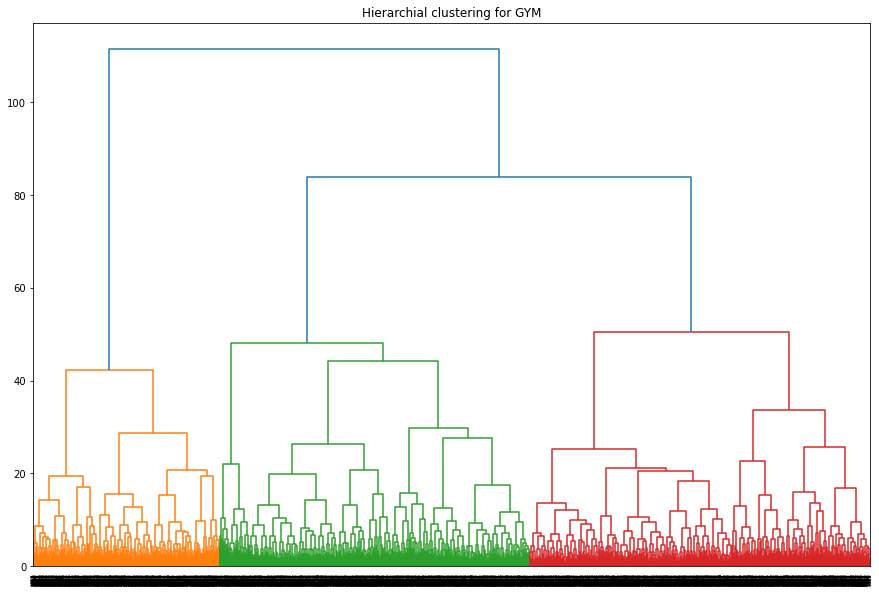

In [23]:
# нарисуем дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show() 

По рисунку нам предлагают 3 кластера, но для прогноза кластеров я возьму 5

In [24]:
# задаём модель k_means с числом кластеров 5 
km =  KMeans(n_clusters=5, random_state=0) 
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)
labels = km.fit_predict(df_new)

In [33]:
# Посмотрим на средние значения признаков для кластеров
df['cluster'] = labels
df.groupby(['cluster']).mean().T.style.format('{:.3f}').background_gradient(cmap='Blues', axis=1)

cluster,0,1,2,3,4
gender,0.534,0.523,0.529,0.494,0.488
Near_Location,0.908,0.843,0.872,0.777,0.930
Partner,0.675,0.419,0.451,0.361,0.725
Promo_friends,0.444,0.284,0.296,0.194,0.486
Phone,0.898,0.907,0.862,0.907,0.916
Contract_period,9.298,2.652,3.542,1.327,12.000
Group_visits,0.495,0.411,0.461,0.312,0.542
Age,29.913,30.056,29.987,27.727,29.894
Avg_additional_charges_total,166.044,156.962,148.809,123.838,162.256
Month_to_end_contract,8.611,2.539,3.215,1.269,10.805


Из таблицы можно заметить что наиболее выделяется 3 кластер у него самое высокое значение оттока, а остальные признаки наоборот в среднем меньше чем в остальных кластерах.

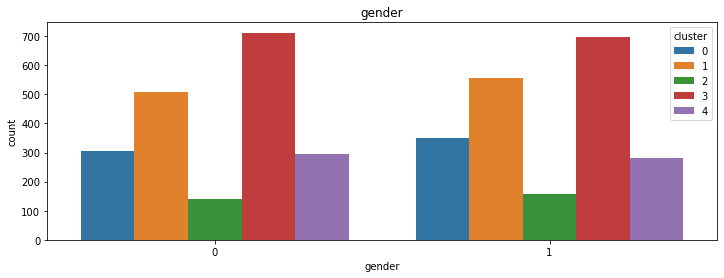

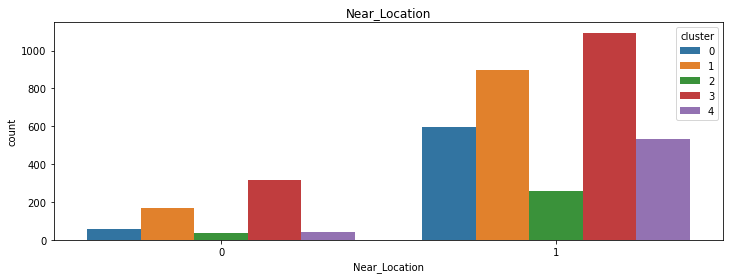

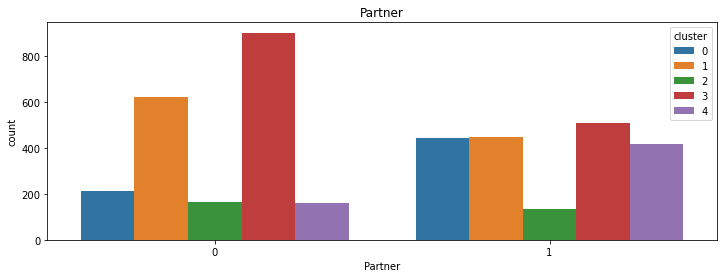

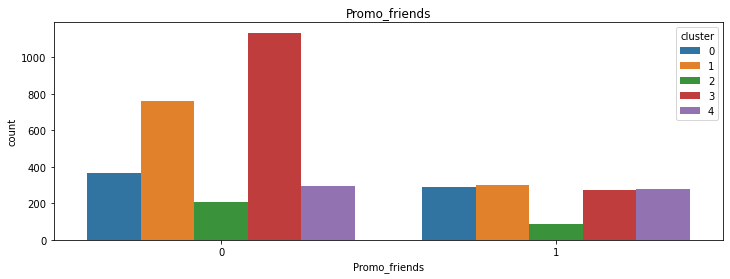

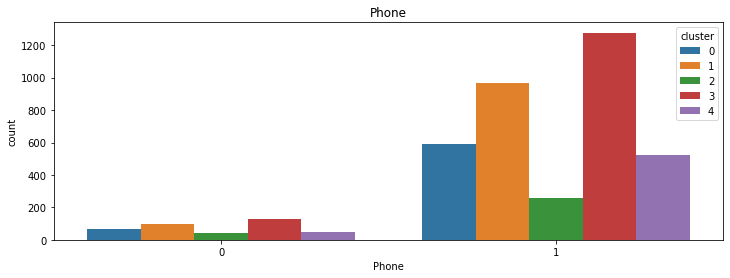

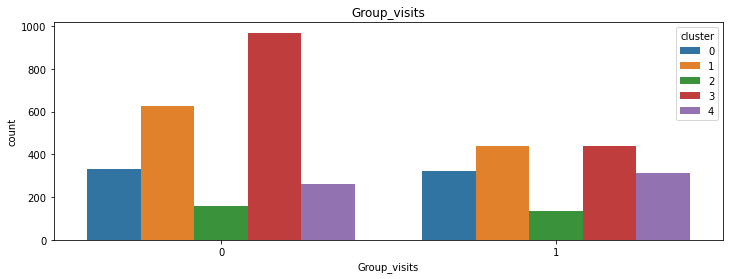

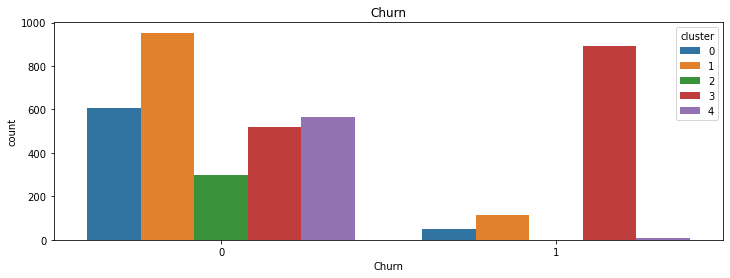

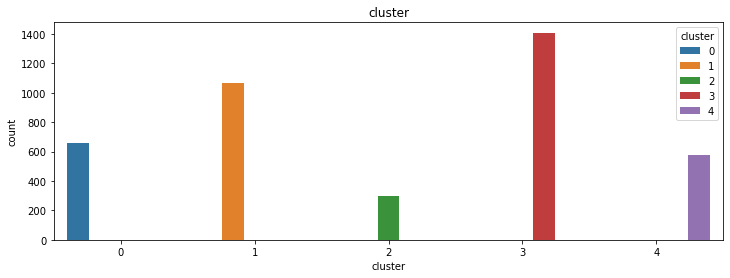

In [28]:
categorical_columns = df[['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 'Group_visits', 'Churn', 'cluster']]

for column in categorical_columns:
    plt.figure(figsize=(12, 4))
    sns.countplot(x=df[column], hue="cluster", data=df)
    plt.title(column)
    plt.show()

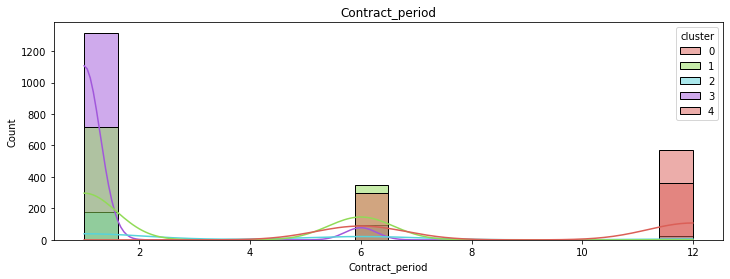

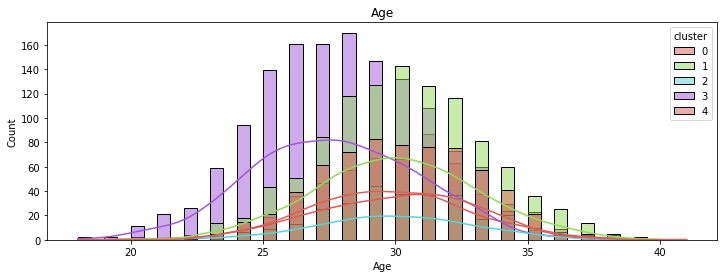

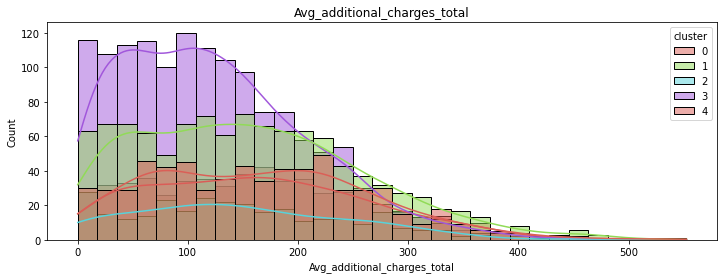

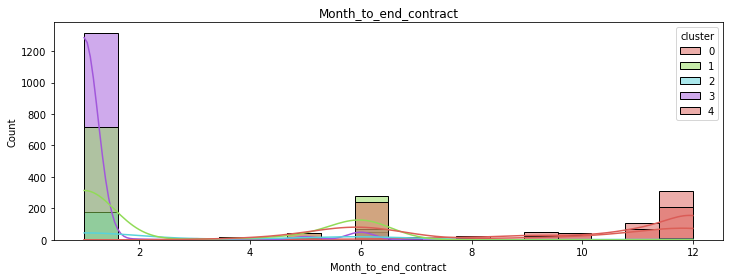

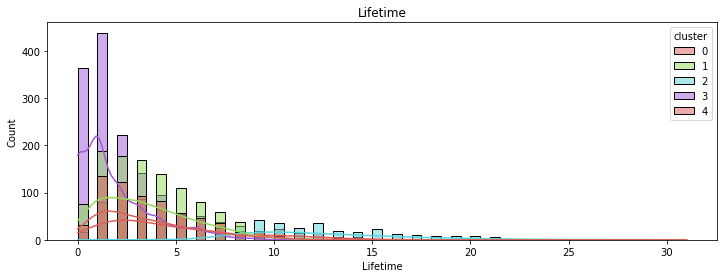

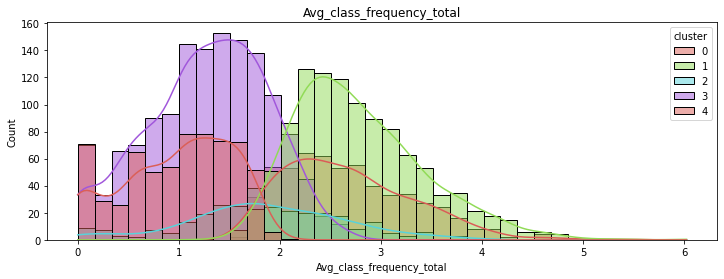

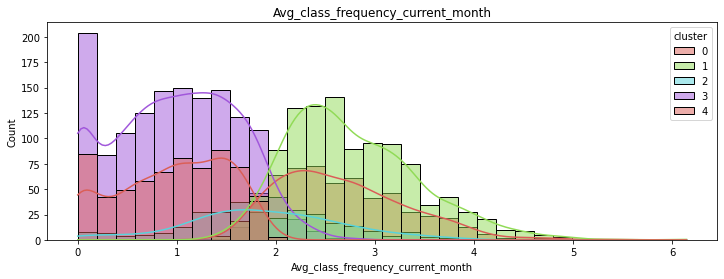

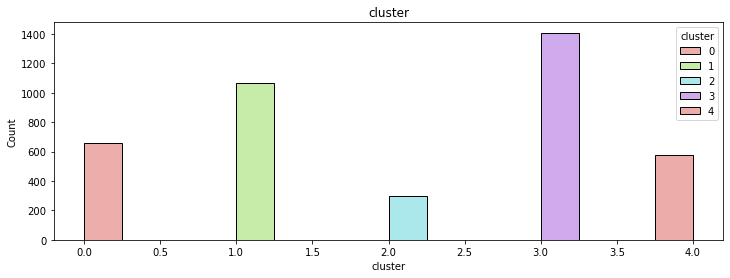

In [40]:
numeric_columns = df[['Contract_period', 'Age', 'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime', 'Avg_class_frequency_total', 'Avg_class_frequency_current_month', 'cluster']]

for column in numeric_columns:
    plt.figure(figsize=(12, 4))
    sns.histplot(x=df[column], hue="cluster", kde=True, palette='hls', data=df)
    plt.title(column)
    plt.show()

Наиболее перспективными кластерами выглядят 0, 2 и 4. У 2 кластера к примеру можно выделить самый большой средний лайфтайм свыше 12 месяцев, что было наиболее важным признаком в прогнозировании моделью случйного леса.

## Шаг 5. Сформулируем выводы и сделаем базовые рекомендации по работе с клиентами

В этом проекте я сформировал типичные портреты клиентов: выделил несколько наиболее ярких групп и охарактеризовал их основные свойства. Проанализировал основные признаки, наиболее сильно влияющие на отток. С помощью моделей машинного обучения логистической регрессией и случайного леса (обе модели показали примерно одинаковый, хороший результат), построил модель прогнозирования вероятности оттока (на уровне следующего месяца) для каждого клиента. С помощью кластеризации выделил целевые группы клиентов. Кластерами с наименьшим оттоком стали 0, 2 и 4 они имеют некоторые общие характерные признаки, к примеру длительность текущего действующего абонемента в этих кластерах больше чем в других, отсюда можно рекомендовать акцентировать внимание на продаже абонементов длительного действия. Также стоит обратить внимание на то, чем дольше клиент посещает зал, тем более снижается вероятность оттока клиента в следующем месяце. Еще стоит отметить что во всех 3 кластерах с наименьшим оттоком, доля тех кто пришел в рамках акции «приведи друга» выше чем в других, поэтому стоит обратить дополнительное внимание к этой акции, ну и последняя рекомендациия на что можно обратить внимание это групповые занятия здесь также с повышением доли посещающих их, снижается доля оттока в кластерах. А количество посещений в неделю как видно по кластерам не имеет зависимости с фактором оттока.